<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [89]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

C:\Users\ryblo\AppData\Local\Temp\ipykernel_20548\2230366340.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

### 1. Посмотрим на случайные строки

Это можно сделать с помощью метода `.sample(n=10, random_state=42)` с указанием количества строк `n` и `random_state` для воспроизводимости вычислений.  
Я посмотрел 30 рандомных строк, но в коде оставил 10 для более удобного просмотра. Визуально не видно пропущенных значений - проверим это формально в следующем разделе.  
Также можно посмотреть на начало и конец датасета с помощью методов `.head(n=10)` и `.tail(n=10)`, соответственно. 

In [5]:
data.sample(n=10, random_state=42)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
3964,44,100.10,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
240,25,20.95,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
1942,39,50.75,2011.4,Female,0,No,No,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1859,52,79.20,4016.3,Male,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Electronic check,0
2348,1,74.40,74.4,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
2280,6,50.80,288.05,Female,0,No,No,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),1
733,21,68.65,1493.2,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0


### 2. Посмотрим на данные

В данном разделе посмотрим на то какие колонки у нас есть, какого они типа, сколько ненулевых значений.

In [6]:
data.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

(None, None)

Всего у нас в выборке для обучения `5282` строки. В тестовой выборке `1761` объект. Пропущенных значений нет. Подтвердим это еще раз.  
Это можно сделать с помощью методов `.isna()` или `.isnull()` - насколько я понимаю, они эквивалентны.  
`data.isnull()` для каждого значения пишет `True`, если оно пропущено и `False` в обратном случае.  
`data.isnull().any()` показывает (агреггировано) есть ли пропущенные значения в колонках.  
`data.isnull().values.any()` обощает решение о пропущенных значениях на весь датасет.  

In [7]:
assert data.isnull().values.any() == False

Действительно пропущенных значений нет, но ранее было указано, что колонка `TotalSpent` содержит числовые значения, а в данных она строковая - посмотрим на нее. 

In [8]:
data["TotalSpent"].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

Видим, что 9 раз повторяется в данных пустая строка. Проверим это.

In [9]:
data[data["TotalSpent"] == " "]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Так и есть. Заменим пустые строки на `NaN` во всем датасете. И поменяем тип колонки `TotalSpent` на `float`.

In [10]:
data.replace(r'^\s*$', np.nan, regex=True, inplace=True)
data["TotalSpent"] = data["TotalSpent"].astype("float")
data.isna().any(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5273 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

(ClientPeriod                False
 MonthlySpending             False
 TotalSpent                   True
 Sex                         False
 IsSeniorCitizen             False
 HasPartner                  False
 HasChild                    False
 HasPhoneService             False
 HasMultiplePhoneNumbers     False
 HasInternetService          False
 HasOnlineSecurityService    False
 HasOnlineBackup             False
 HasDeviceProtection         False
 HasTechSupportAccess        False
 HasOnlineTV                 False
 HasMovieSubscription        False
 HasContractPhone            False
 IsBillingPaperless          False
 PaymentMethod               False
 Churn                       False
 dtype: bool,
 None)

Сделаем тоже самое для тестового датасета, так как там тоже есть пропущенные значения в этой колонке.  
И вообще проверим есть ли еще пустые строки в датасете

In [11]:
print(f"В тестовом датасете в колонке 'TotalSpent' есть {test['TotalSpent'].value_counts()[' ']} пустых значения")
test.replace(r'^\s*$', np.nan, regex=True, inplace=True)
test["TotalSpent"] = test["TotalSpent"].astype("float")
test.isna().any(), test.info()

В тестовом датасете в колонке 'TotalSpent' есть 2 пустых значения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1759 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 1

(ClientPeriod                False
 MonthlySpending             False
 TotalSpent                   True
 Sex                         False
 IsSeniorCitizen             False
 HasPartner                  False
 HasChild                    False
 HasPhoneService             False
 HasMultiplePhoneNumbers     False
 HasInternetService          False
 HasOnlineSecurityService    False
 HasOnlineBackup             False
 HasDeviceProtection         False
 HasTechSupportAccess        False
 HasOnlineTV                 False
 HasMovieSubscription        False
 HasContractPhone            False
 IsBillingPaperless          False
 PaymentMethod               False
 dtype: bool,
 None)

### Итоги

В итоге, пока что попробуем не избавляться от пропущенных значений (а потом посмотрим), потому что их мало и градиентные бустинги, типа XGBoost или LightGBM могут их автоматически обрабатывать.  

В этом разделе мы посмотрели на наш датасет, заметили, что колонка `TotalSpent` имеет неправильный тип и пропущенные значения в виде пустой строки и поправили это.

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*).  
Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, если вы сможете это сделать на одном графике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

### 1.1 Числовые признаки

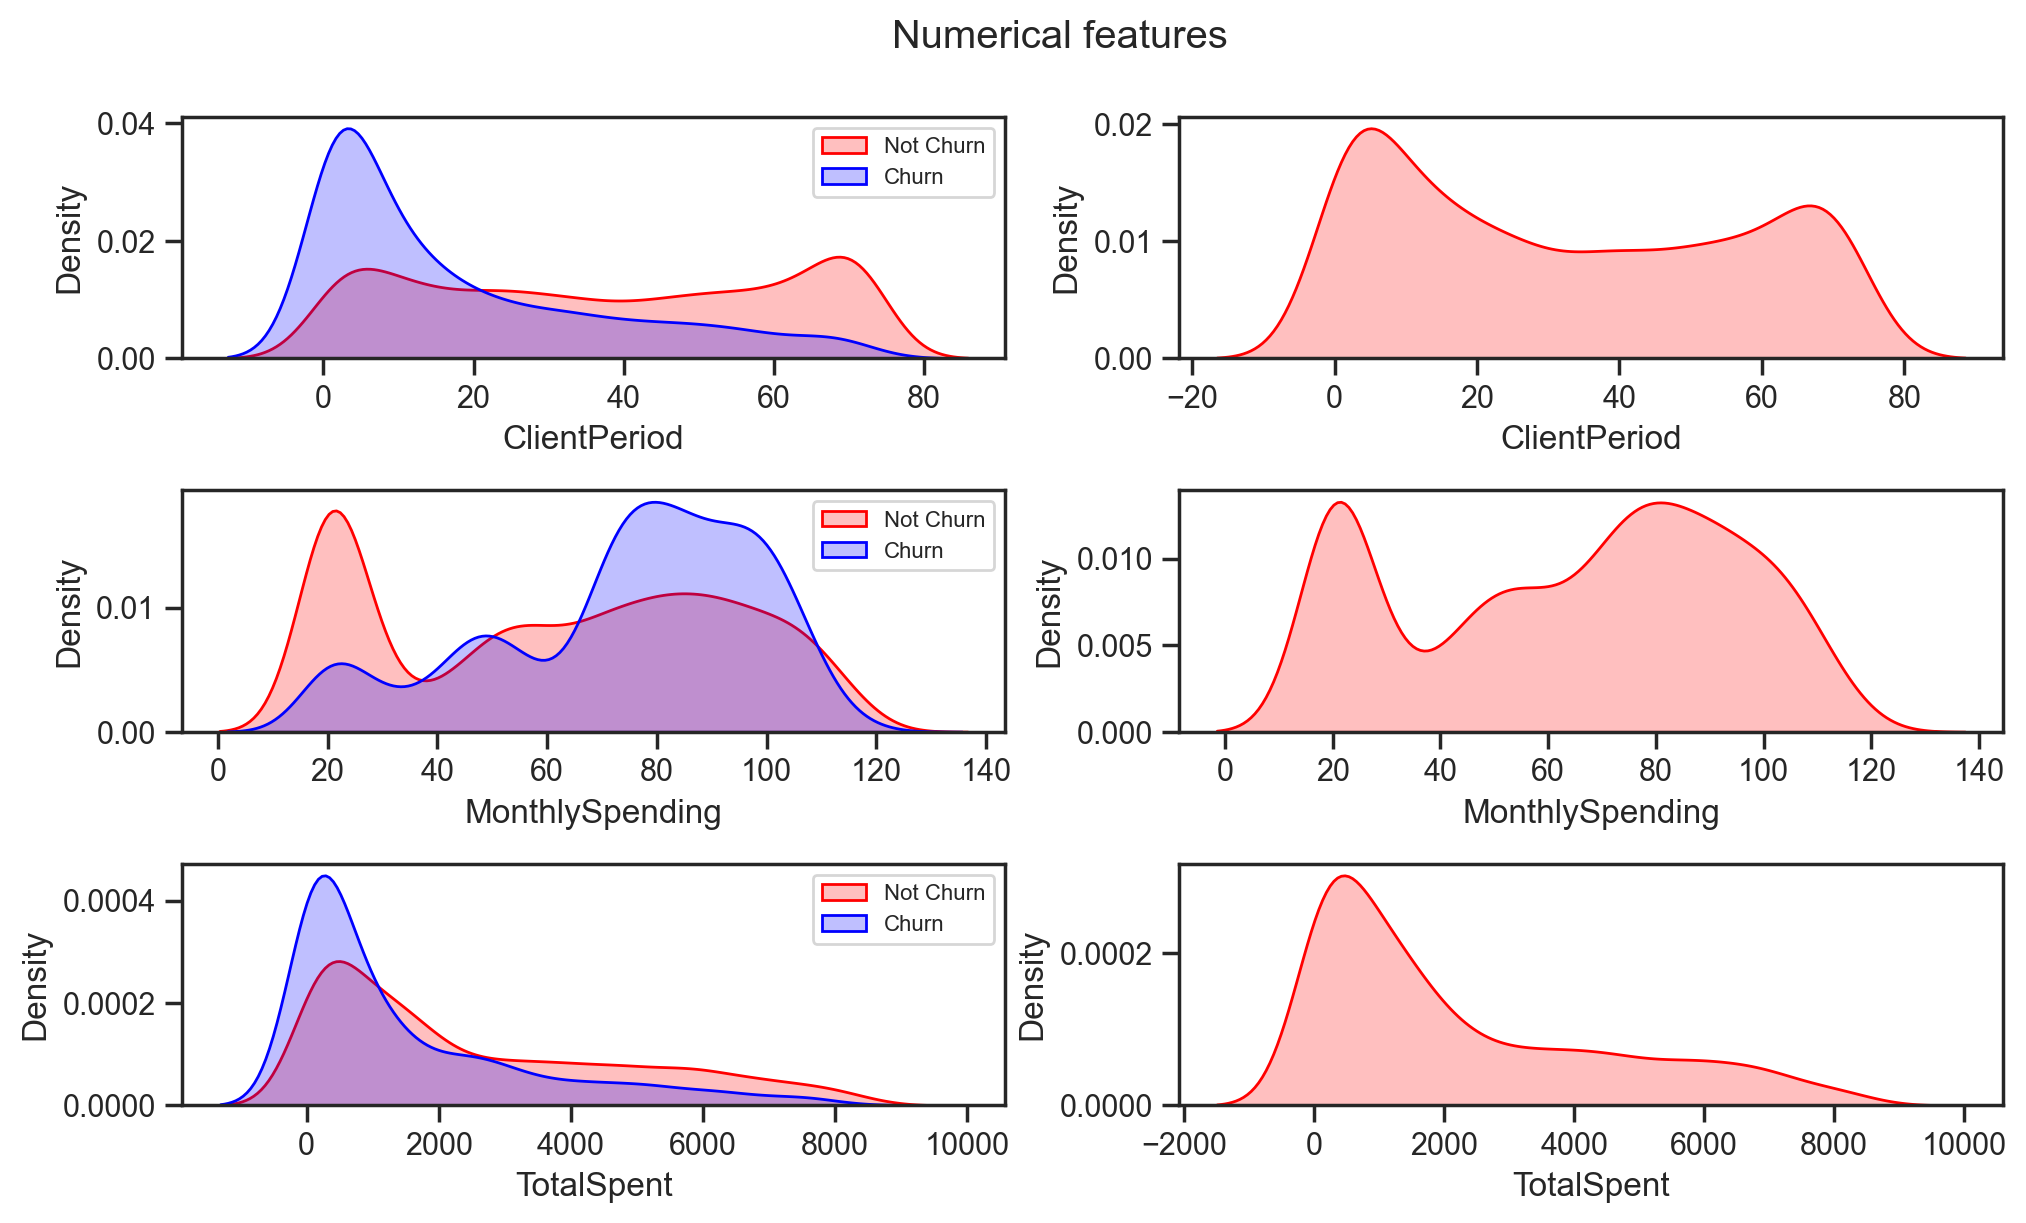

In [128]:
fig, axs = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(10, 6)) # Инициализируем 3 подграфика с определенным размером
fig.suptitle('Numerical features') # Общее название для группы графиков
fig.tight_layout(h_pad=2, w_pad=2) # для того, чтобы графики не стояли слишком близко друг к другу

for i, num_feature in enumerate(num_cols):
    g1 = sns.kdeplot(data[data[target_col]==0][num_feature], ax = axs[i, 0], color="red", shade=True)
    g1 = sns.kdeplot(data[data[target_col]==1][num_feature], ax = axs[i, 0], color="blue", shade=True)
    g1.legend(["Not Churn", "Churn"], fontsize=8) 
    
    g2 = sns.kdeplot(test[num_feature], ax = axs[i, 1], color="red", shade=True)

Как аналог гистограмме, можно использовать [KDE график](https://ru.wikipedia.org/wiki/%D0%AF%D0%B4%D0%B5%D1%80%D0%BD%D0%B0%D1%8F_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BF%D0%BB%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B8#%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) - с помощью него проще визуализировать и интерпретировать данные.  
**1 колонка**  
В каждый график для числового признака я добавил 2 подграфика: в одном используются данные, у которых `churn == 0`, у другого `churn == 1`. Это помогает увидеть разницу в том как распределены данные и позволяет предположить насколько полезен будет признак для предсказания целевой переменной.  

*Видно, что для первых двух признаков есть существенные различия в том, как данные распределены для разных классов. Да и в третьем есть различия, но не такие существенные*

**2 колонка**  
Добавил распределение данные в тестовой выборке, чтобы посмотреть нет ли существенных различий между тренировочными и тестовыми данными (их нет).

### 1.1 Категориальные признаки

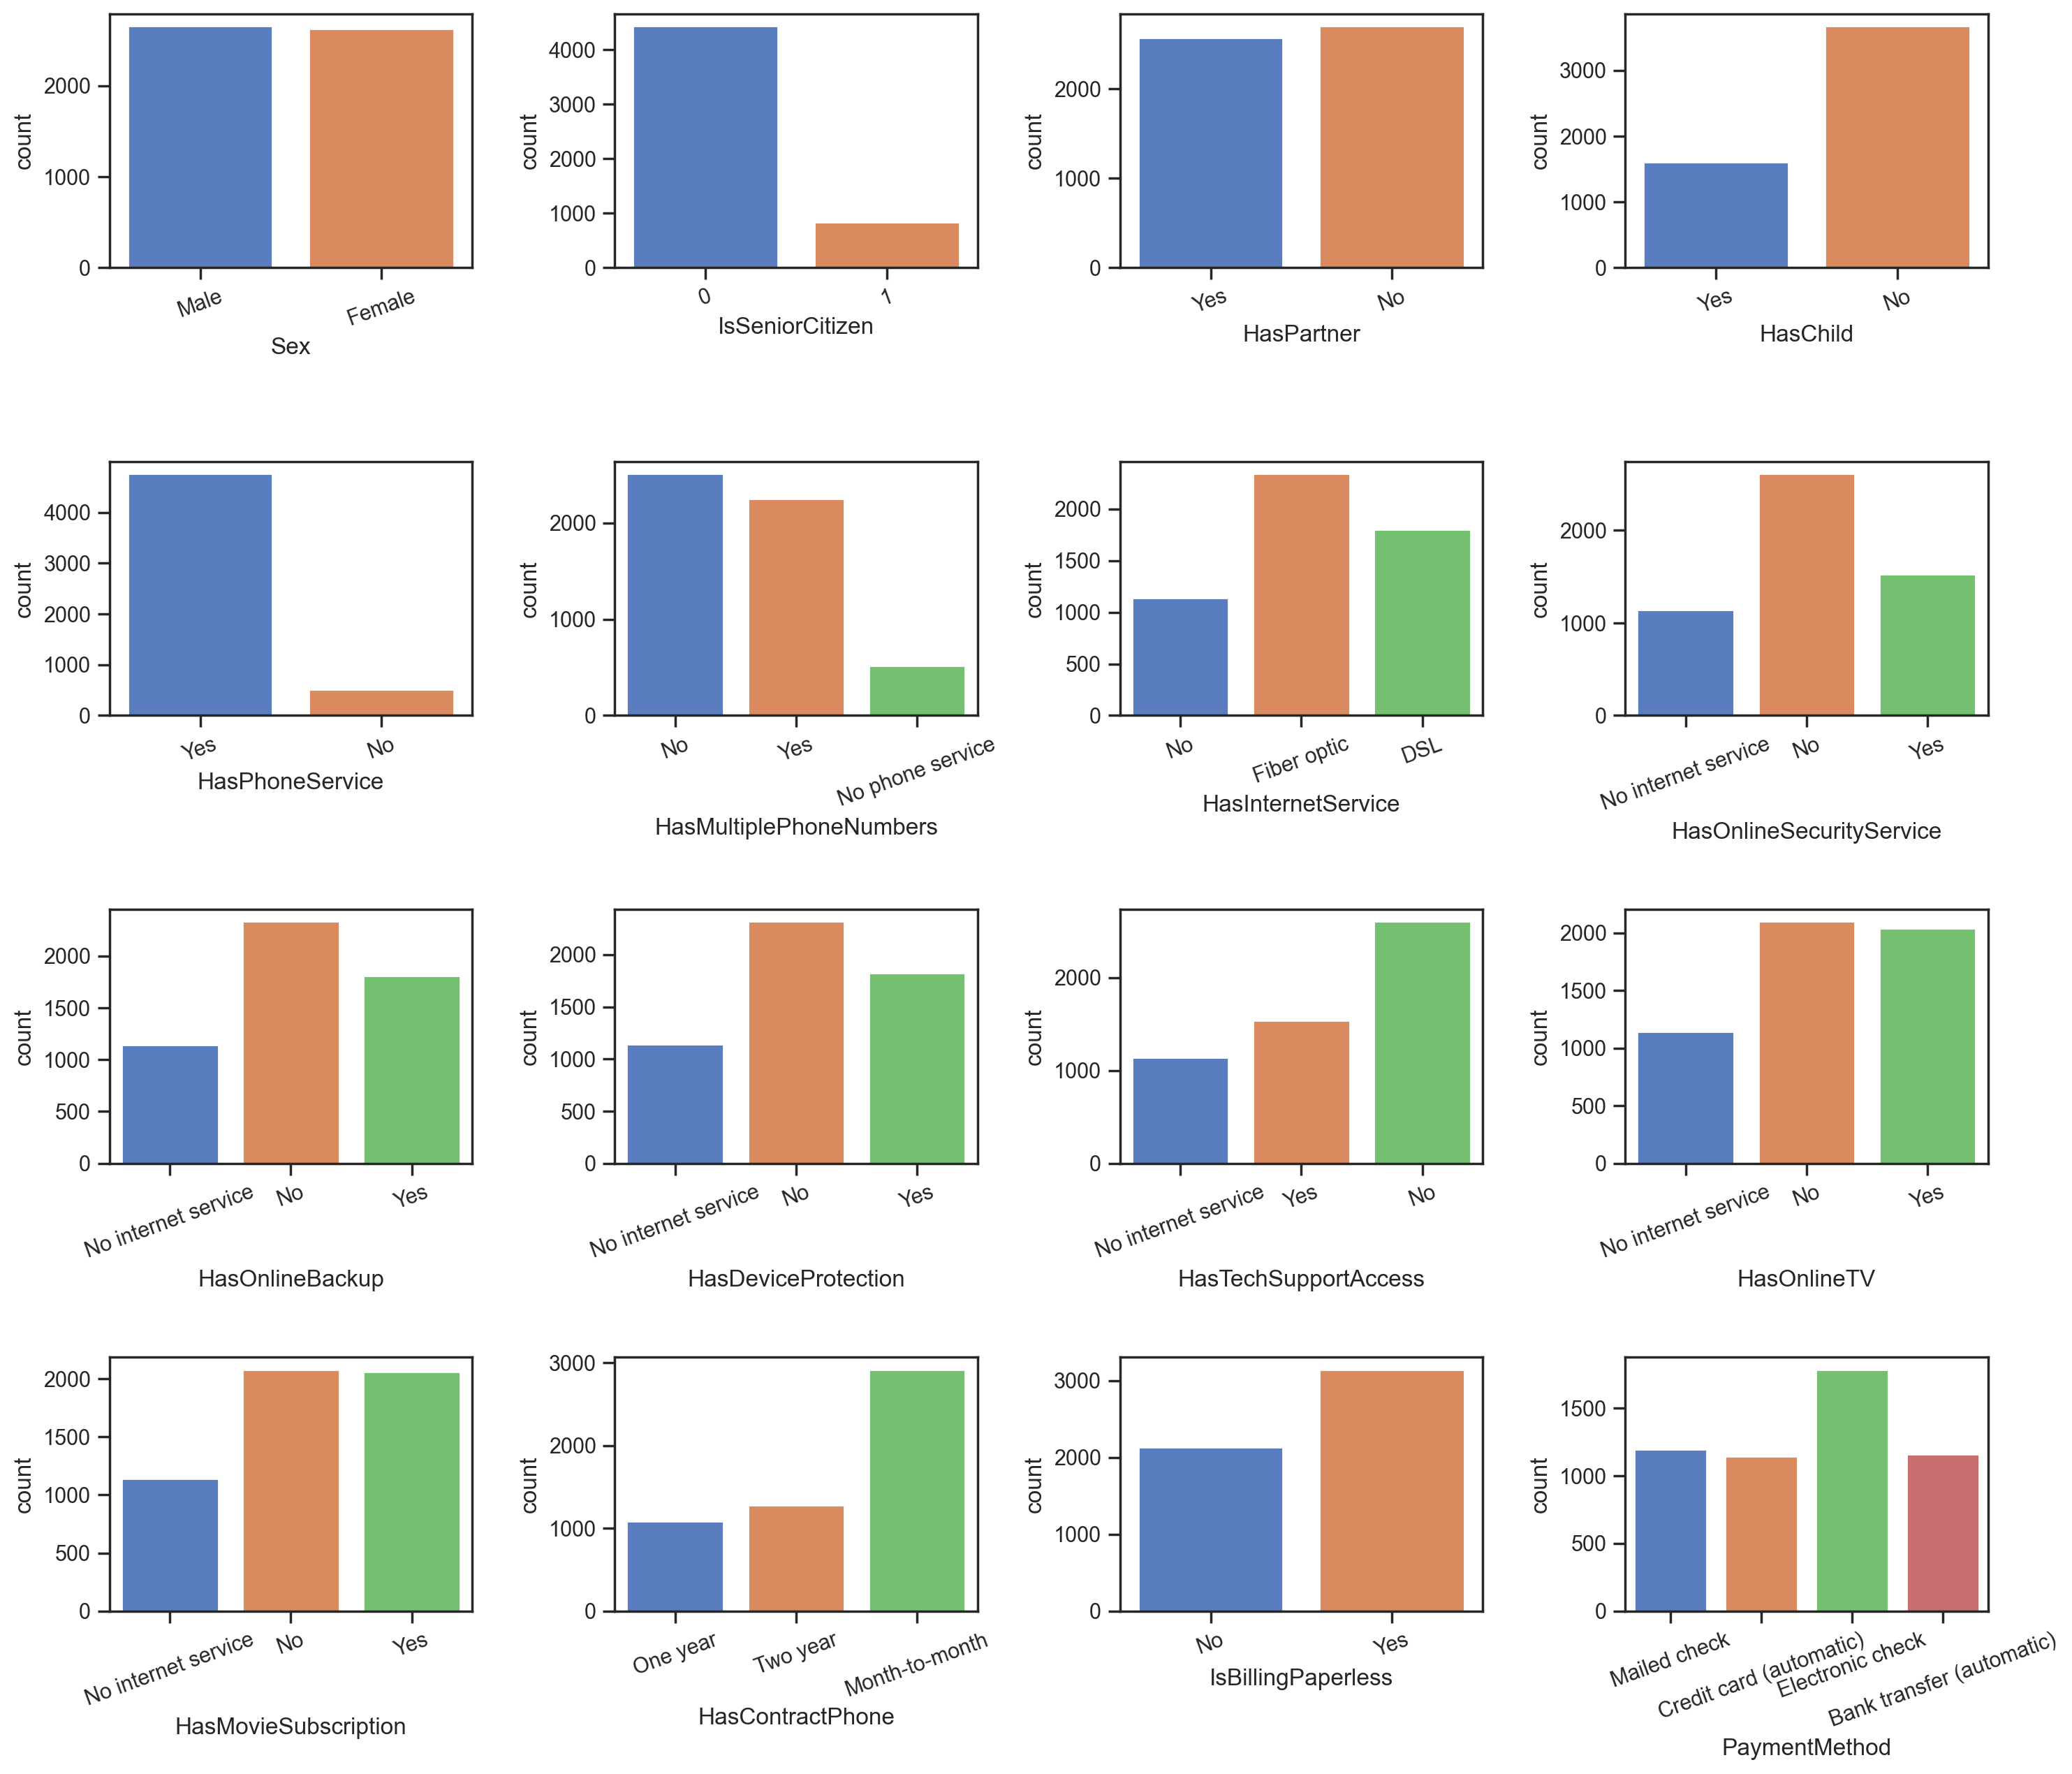

In [182]:
col_nums = 4
row_nums = len(cat_cols) // col_nums + 1
plt.figure(figsize=(15, 15))

for i, cat_feature in enumerate(cat_cols):
    plt.subplot(row_nums, col_nums, i + 1)
    g = sns.countplot(x=cat_feature, data=data, palette="muted")
    plt.xticks(rotation=20)

plt.tight_layout(h_pad=2)
plt.show()

Выводы

### 2. Распределение целевой переменной

C:\Users\ryblo\Documents\projects\deep_learning_school\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


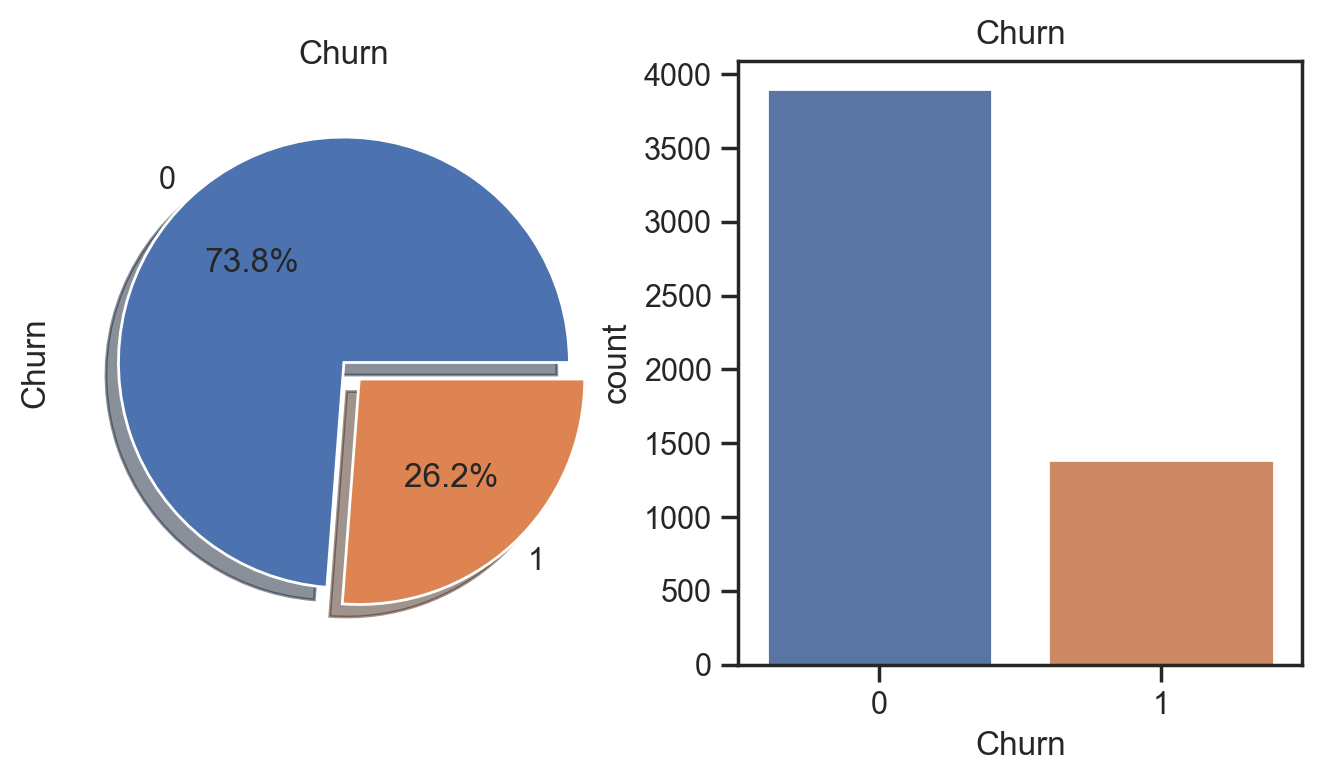

In [186]:
f,ax=plt.subplots(1,2,figsize=(8,4))
data[target_col].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title(target_col)
ax[0].set_ylabel(target_col)
sns.countplot(target_col,data=data,ax=ax[1])
ax[1].set_title(target_col)
plt.show()

Выводы

### 3 Категориальные признаки vs Churn

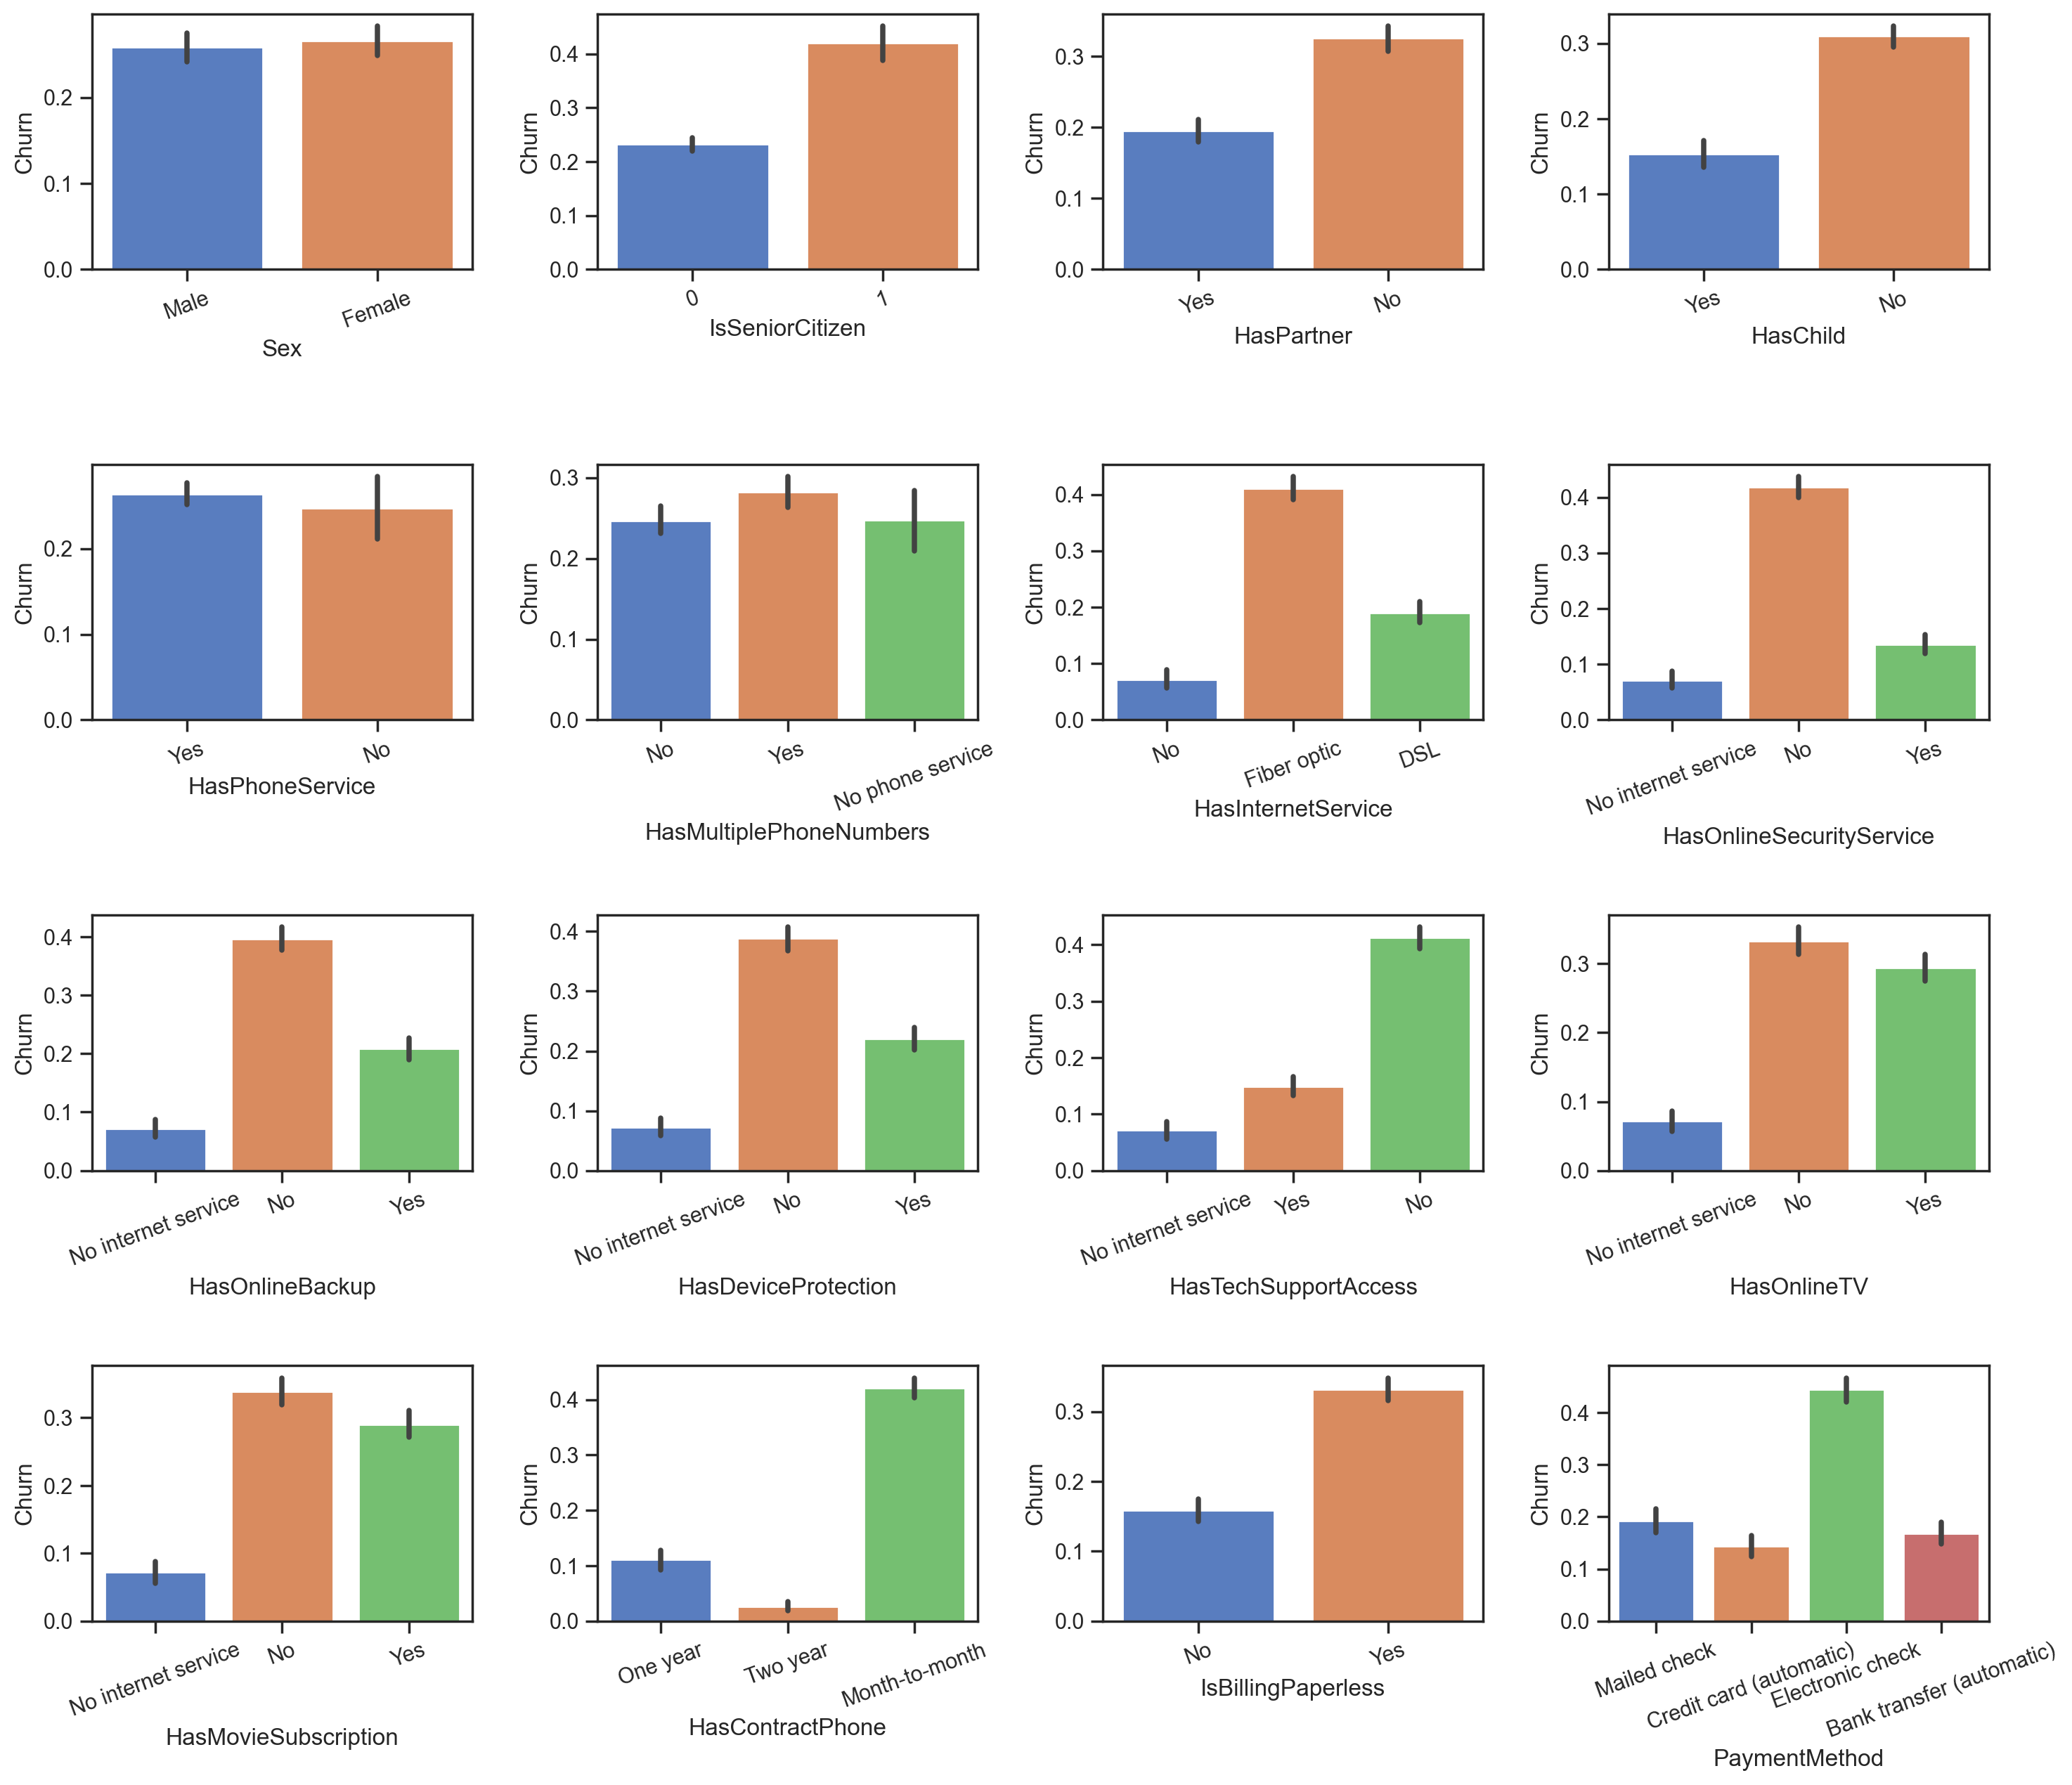

In [181]:
col_nums = 4
row_nums = len(cat_cols) // col_nums + 1
plt.figure(figsize=(15, 15))

for i, cat_feature in enumerate(cat_cols):
    plt.subplot(row_nums, col_nums, i + 1)
    g = sns.barplot(x=cat_feature, y=target_col, data=data, palette="muted")
    plt.xticks(rotation=20)

plt.tight_layout(h_pad=2)
plt.show()

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [ ]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
# YOUR CODE

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [ ]:
# YOUR CODE

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [ ]:
best_model = # какая-то предыдущая модель

SyntaxError: invalid syntax (<ipython-input-12-7d881febecc7>, line 1)

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = # best_model.predict_proba(X_test) / best_model.predict(X_test)
submission.to_csv('./my_submission.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.